In [ ]:
import os
from pathlib import Path

import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from rasterio.plot import show
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from rasterio.features import rasterize

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
base_path = Path('/content/drive/MyDrive/Colab Notebooks/506_project/data')
parks_dir = base_path / 'park'
landsat_dir = base_path / 'landsat_1'

# **Sanity Check**

In [ ]:
parks_shp = parks_dir / 'park.shp'
assert parks_shp.exists(), f"Cannot find: {parks_shp}"

parks = gpd.read_file(parks_shp)

print("\n--- Parks shapefile ---")
print("Rows:", len(parks))
print("Columns:", list(parks.columns))
print("CRS:", parks.crs)
print("Geometry types:", parks.geometry.geom_type.value_counts().to_dict())
print("Bounds (minx, miny, maxx, maxy):", parks.total_bounds)


--- Parks shapefile ---
Rows: 617
Columns: ['objectid_1', 'park_no', 'park', 'location', 'zip', 'acres', 'ward', 'park_class', 'label', 'gisobjid', 'wheelchr_a', 'archery_ra', 'artificial', 'band_shell', 'baseball_b', 'basketball', 'basketba_1', 'beach', 'boat_launc', 'boat_lau_1', 'boat_slips', 'bocce_cour', 'bowling_gr', 'casting_pi', 'football_s', 'community_', 'conservato', 'cultural_c', 'dog_friend', 'fitness_ce', 'fitness_co', 'gallery', 'garden', 'golf_cours', 'golf_drivi', 'golf_putti', 'gymnasium', 'gymnastic_', 'handball_r', 'horseshoe_', 'iceskating', 'pool_indoo', 'baseball_j', 'mountain_b', 'nature_cen', 'pool_outdo', 'zoo', 'playground', 'playgrou_1', 'rowing_clu', 'volleyball', 'senior_cen', 'shuffleboa', 'skate_park', 'sled_hill', 'sport_roll', 'spray_feat', 'baseball_s', 'tennis_cou', 'track', 'volleyba_1', 'water_play', 'water_slid', 'boxing_cen', 'wetland_ar', 'lagoon', 'cricket_fi', 'climbing_w', 'game_table', 'carousel', 'croquet', 'handball_i', 'harbor', 'modeltr

In [ ]:
st_files = sorted(landsat_dir.glob("*_ST_B10.TIF")) + sorted(landsat_dir.glob("*_ST_B10.tif"))
mtl_files = sorted(landsat_dir.glob("*_MTL.txt")) + sorted(landsat_dir.glob("*_MTL.TXT"))

print("\n--- Landsat scan ---")
print("ST_B10 files:", len(st_files))
print("MTL files:", len(mtl_files))

print("\nSample ST_B10:", [p.name for p in st_files[:3]])
print("Sample MTL:", [p.name for p in mtl_files[:3]])

assert len(st_files) > 0, "No ST_B10 TIF found in landsat_1/"


--- Landsat scan ---
ST_B10 files: 18
MTL files: 18

Sample ST_B10: ['LC08_L2SP_022031_20240522_20240605_02_T1_ST_B10.TIF', 'LC08_L2SP_022031_20240607_20240627_02_T1_ST_B10.TIF', 'LC08_L2SP_022031_20240725_20240801_02_T1_ST_B10.TIF']
Sample MTL: ['LC08_L2SP_022031_20240522_20240605_02_T1_MTL.txt', 'LC08_L2SP_022031_20240607_20240627_02_T1_MTL.txt', 'LC08_L2SP_022031_20240725_20240801_02_T1_MTL.txt']


In [ ]:
sample_tif = st_files[0]
print("\nOpening sample raster:", sample_tif.name)

with rasterio.open(sample_tif) as src:
    band = src.read(1).astype("float32")
    nodata = src.nodata
    profile = src.profile
    bounds = src.bounds
    crs = src.crs

print("\n--- Raster info ---")
print("CRS:", crs)
print("Bounds:", bounds)
print("Shape:", band.shape)
print("NoData:", nodata)
print("Dtype:", band.dtype)

if nodata is not None:
    band[band == nodata] = np.nan


Opening sample raster: LC08_L2SP_022031_20240522_20240605_02_T1_ST_B10.TIF

--- Raster info ---
CRS: EPSG:32616
Bounds: BoundingBox(left=399585.0, bottom=4504485.0, right=632115.0, top=4740615.0)
Shape: (7871, 7751)
NoData: 0.0
Dtype: float32



--- Quick value check (°C) ---
Min/Max (ignoring NaN): 2.1390076 57.14862
Mean: 25.721579


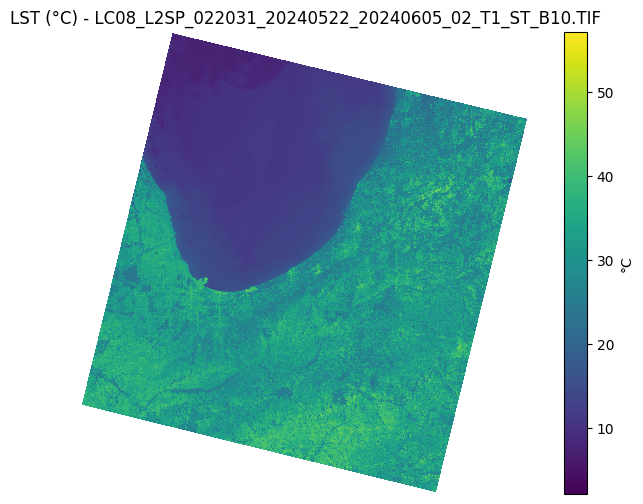

In [ ]:
lst_c = (band * 0.00341802 + 149.0) - 273.15

print("\n--- Quick value check (°C) ---")
print("Min/Max (ignoring NaN):", np.nanmin(lst_c), np.nanmax(lst_c))
print("Mean:", np.nanmean(lst_c))

plt.figure(figsize=(8, 6))
plt.imshow(lst_c, interpolation="none")
plt.title(f"LST (°C) - {sample_tif.name}")
plt.colorbar(label="°C")
plt.axis("off")
plt.show()

# **Load shapefile to get 'Chicago'**

In [ ]:
neigh_dir = base_path / 'neighborhoods'

neigh_shps = sorted(neigh_dir.glob("*.shp"))
assert len(neigh_shps) > 0, f"No .shp found in {neigh_dir}"
neigh_shp = neigh_shps[0]
print("Using neighborhoods shapefile:", neigh_shp.name)

neigh = gpd.read_file(neigh_shp)
print("Neighborhoods rows:", len(neigh))
print("Neighborhoods CRS:", neigh.crs)
print("Neighborhoods geometry types:", neigh.geometry.geom_type.value_counts().to_dict())

Using neighborhoods shapefile: geo_export_a4ee3fab-9131-465d-b497-0c618c0dc6be.shp
Neighborhoods rows: 98
Neighborhoods CRS: EPSG:4326
Neighborhoods geometry types: {'Polygon': 96, 'MultiPolygon': 2}


In [ ]:
# Dissolve all neighborhoods -> single Chicago boundary polygon
chicago = neigh.dissolve()
chicago = chicago.set_geometry(chicago.geometry)
print("Chicago boundary rows (after dissolve):", len(chicago))

# one sample raster
sample_tif = st_files[0]
print("Sample raster:", sample_tif.name)

import rasterio
with rasterio.open(sample_tif) as ds:
    raster_crs = ds.crs
    nodata = ds.nodata
    transform = ds.transform

print("Raster CRS:", raster_crs, "| NoData:", nodata)

Chicago boundary rows (after dissolve): 1
Sample raster: LC08_L2SP_022031_20240522_20240605_02_T1_ST_B10.TIF
Raster CRS: EPSG:32616 | NoData: 0.0


In [ ]:
# Reproject chicago boundary + parks to raster CRS
chicago_utm = chicago.to_crs(raster_crs)
parks_utm = parks.to_crs(raster_crs)

# Clip raster to Chicago boundary
geom = [chicago_utm.geometry.iloc[0].__geo_interface__]

with rasterio.open(sample_tif) as ds:
    clipped_dn, clipped_transform = mask(
        ds, geom, crop=True, filled=True, nodata=0
    )
    clipped_dn = clipped_dn[0].astype("float32")

Clipped raster shape: (1405, 1143)
Clipped °C min/max: 11.760712 54.42447


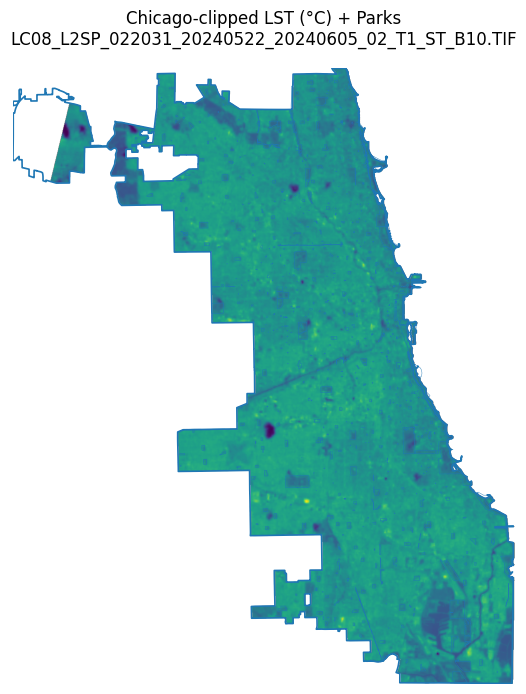

In [ ]:
# DN -> Celsius
clipped_dn[clipped_dn == 0] = np.nan
clipped_c = (clipped_dn * 0.00341802 + 149.0) - 273.15

print("Clipped raster shape:", clipped_c.shape)
print("Clipped °C min/max:", np.nanmin(clipped_c), np.nanmax(clipped_c))

# 8) Plot Chicago-clipped LST + Chicago boundary + Parks
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
show(clipped_c, transform=clipped_transform, ax=ax)
chicago_utm.boundary.plot(ax=ax, linewidth=1.2)
parks_utm.boundary.plot(ax=ax, linewidth=0.3)
ax.set_title(f"Chicago-clipped LST (°C) + Parks\n{sample_tif.name}")
ax.axis("off")
plt.show()

# **Better visualization: "heat" colormap + green parks outlines**

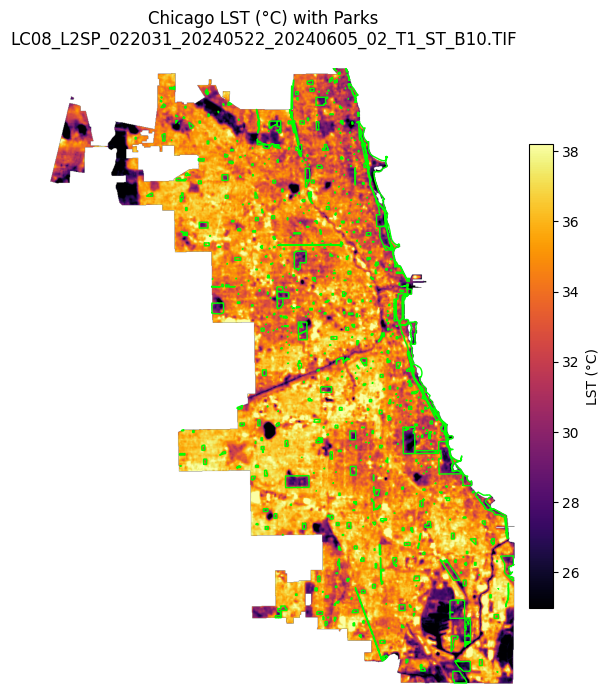

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

vmin = np.nanpercentile(clipped_c, 2)
vmax = np.nanpercentile(clipped_c, 98)

img = ax.imshow(
    clipped_c,
    cmap="inferno",
    vmin=vmin,
    vmax=vmax,
    extent=rasterio.transform.array_bounds(
        clipped_c.shape[0], clipped_c.shape[1], clipped_transform
    )[::2] + rasterio.transform.array_bounds(
        clipped_c.shape[0], clipped_c.shape[1], clipped_transform
    )[1::2],
    origin="upper"
)

plt.colorbar(img, ax=ax, fraction=0.03, pad=0.02, label="LST (°C)")

parks_utm.boundary.plot(ax=ax, color="#00ff00", linewidth=1.0, zorder=5)

ax.set_title(f"Chicago LST (°C) with Parks\n{sample_tif.name}")
ax.axis("off")
plt.show()

# **Compute Park Cooling Intensity (PCI) for *`one scene`* (parks vs ring buffer)**

In [ ]:
parks_in = gpd.overlay(parks_utm, chicago_utm[['geometry']], how='intersection')
parks_in = parks_in[~parks_in.geometry.is_empty].copy()
parks_in = parks_in.reset_index(drop=True)

print("Parks before:", len(parks_utm), " | Parks inside Chicago:", len(parks_in))

Parks before: 617  | Parks inside Chicago: 617


In [ ]:
out_shape = clipped_c.shape

In [ ]:
# zonal mean from polygon on clipped raster
def zonal_mean_from_geom(geom, raster_2d, transform, out_shape):
    """
    Rasterize geom -> mask -> mean of raster_2d within mask (ignores NaN)
    """
    if geom is None or geom.is_empty:
        return np.nan

    mask_arr = rasterize(
        [(geom, 1)],
        out_shape=out_shape,
        transform=transform,
        fill=0,
        dtype="uint8",
        all_touched=False
    ).astype(bool)

    vals = raster_2d[mask_arr]
    if vals.size == 0:
        return np.nan

    return np.nanmean(vals)

In [ ]:
# Define ring buffer (meters)
INNER_M = 100
OUTER_M = 300

In [ ]:
# Loop parks and compute PCI
rows = []
for i, row in parks_in.iterrows():
    geom = row.geometry

    # park stats
    park_mean = zonal_mean_from_geom(geom, clipped_c, clipped_transform, out_shape)

    # ring = buffer(OUTER) - buffer(INNER)
    ring_geom = geom.buffer(OUTER_M).difference(geom.buffer(INNER_M))

    ring_geom = ring_geom.intersection(chicago_utm.geometry.iloc[0])

    ring_mean = zonal_mean_from_geom(ring_geom, clipped_c, clipped_transform, out_shape)

    pci = ring_mean - park_mean

    area_m2 = geom.area

    rows.append({
        "park_idx": i,
        "park_mean_c": park_mean,
        "ring_mean_c": ring_mean,
        "pci_c": pci,
        "area_m2": area_m2,
        "area_acres": area_m2 / 4046.8564224
    })

pci_df = pd.DataFrame(rows)

print("\nPCI summary (°C):")
print(pci_df[["park_mean_c","ring_mean_c","pci_c"]].describe())


PCI summary (°C):
       park_mean_c  ring_mean_c       pci_c
count   579.000000   617.000000  579.000000
mean     33.029772    34.025326    1.027674
std       2.078760     1.687400    1.507837
min      23.563774    26.225269   -5.514168
25%      31.893081    33.034588   -0.011406
50%      33.225052    34.094406    0.828079
75%      34.379486    35.225601    1.916496
max      38.612015    37.953205    6.902653


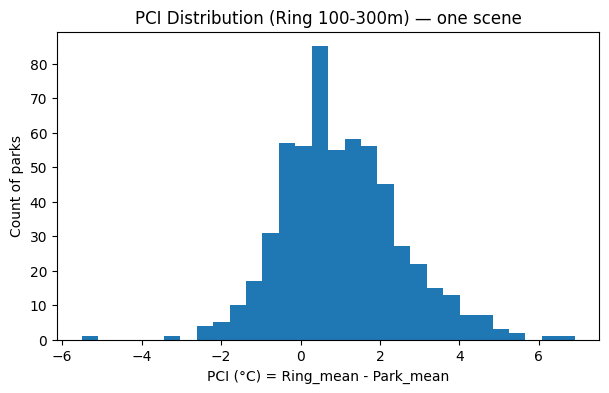

In [ ]:
# PCI distribution
plt.figure(figsize=(7,4))
plt.hist(pci_df["pci_c"].dropna(), bins=30)
plt.title(f"PCI Distribution (Ring {INNER_M}-{OUTER_M}m) — one scene")
plt.xlabel("PCI (°C) = Ring_mean - Park_mean")
plt.ylabel("Count of parks")
plt.show()

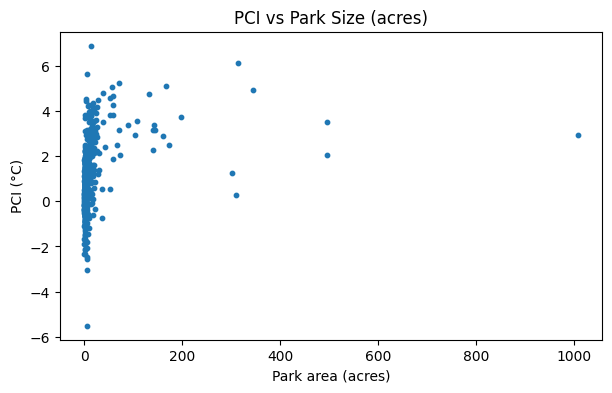

In [ ]:
# PCI vs park size (acres)
plt.figure(figsize=(7,4))
plt.scatter(pci_df["area_acres"], pci_df["pci_c"], s=10)
plt.title("PCI vs Park Size (acres)")
plt.xlabel("Park area (acres)")
plt.ylabel("PCI (°C)")
plt.show()

In [ ]:
# top 10 strongest cooling parks
top10 = pci_df.sort_values("pci_c", ascending=False).head(10)
print("\nTop 10 parks by PCI:")
print(top10[["park_idx","area_acres","park_mean_c","ring_mean_c","pci_c"]])


Top 10 parks by PCI:
     park_idx  area_acres  park_mean_c  ring_mean_c     pci_c
605       605   13.104900    26.709629    33.612282  6.902653
12         12  315.001894    29.674334    35.805649  6.131315
61         61    4.481300    29.382244    35.036968  5.654724
22         22   71.695280    31.027458    36.294491  5.267033
9           9  167.073087    29.992308    35.120831  5.128523
76         76   57.259761    31.243912    36.321056  5.077145
10         10  345.376576    27.914694    32.854858  4.940165
88         88   38.190164    30.899464    35.691956  4.792492
391       391  132.354721    27.331656    32.086929  4.755274
362       362   58.494872    27.745083    32.403721  4.658638


# **Examine PCI over all 18 scenes**

In [ ]:
def zonal_mean_from_geom(geom, raster_2d, transform, out_shape):
    if geom is None or geom.is_empty:
        return np.nan

    mask_arr = rasterize(
        [(geom, 1)],
        out_shape=out_shape,
        transform=transform,
        fill=0,
        dtype="uint8",
        all_touched=False
    ).astype(bool)

    vals = raster_2d[mask_arr]
    if vals.size == 0:
        return np.nan
    return np.nanmean(vals)

In [ ]:
INNER_M = 100
OUTER_M = 300

records = []

for tif_path in st_files:
    print("Processing:", tif_path.name)

    # extract date from filename
    # LC08_L2SP_022031_20240522_20240605_02_T1_ST_B10.TIF
    date_str = tif_path.name.split("_")[4]
    date = pd.to_datetime(date_str, format="%Y%m%d")

    with rasterio.open(tif_path) as ds:
        geom = [chicago_utm.geometry.iloc[0].__geo_interface__]
        clipped_dn, clipped_transform = mask(ds, geom, crop=True, filled=True, nodata=0)
        clipped_dn = clipped_dn[0].astype("float32")
        clipped_dn[clipped_dn == 0] = np.nan

    clipped_c = (clipped_dn * 0.00341802 + 149.0) - 273.15
    out_shape = clipped_c.shape

    for i, row in parks_utm.iterrows():
        geom_park = row.geometry

        park_mean = zonal_mean_from_geom(
            geom_park, clipped_c, clipped_transform, out_shape
        )

        ring_geom = geom_park.buffer(OUTER_M).difference(
        geom_park.buffer(INNER_M)
        )
        ring_geom = ring_geom.intersection(chicago_utm.geometry.iloc[0])

        ring_mean = zonal_mean_from_geom(
            ring_geom, clipped_c, clipped_transform, out_shape
        )

        pci = ring_mean - park_mean

        records.append({
            "park_idx": i,
            "date": date,
            "pci_c": pci,
            "park_mean_c": park_mean,
            "ring_mean_c": ring_mean,
            "area_acres": row.geometry.area / 4046.8564224
        })

Processing: LC08_L2SP_022031_20240522_20240605_02_T1_ST_B10.TIF


/tmp/ipython-input-3373046273.py:17: RuntimeWarning: Mean of empty slice
  return np.nanmean(vals)


Processing: LC08_L2SP_022031_20240607_20240627_02_T1_ST_B10.TIF


/tmp/ipython-input-3373046273.py:17: RuntimeWarning: Mean of empty slice
  return np.nanmean(vals)


Processing: LC08_L2SP_022031_20240725_20240801_02_T1_ST_B10.TIF


/tmp/ipython-input-3373046273.py:17: RuntimeWarning: Mean of empty slice
  return np.nanmean(vals)


Processing: LC08_L2SP_022031_20240810_20240815_02_T1_ST_B10.TIF


/tmp/ipython-input-3373046273.py:17: RuntimeWarning: Mean of empty slice
  return np.nanmean(vals)


Processing: LC08_L2SP_022031_20240826_20240831_02_T1_ST_B10.TIF


/tmp/ipython-input-3373046273.py:17: RuntimeWarning: Mean of empty slice
  return np.nanmean(vals)


Processing: LC08_L2SP_022031_20240911_20240920_02_T1_ST_B10.TIF


/tmp/ipython-input-3373046273.py:17: RuntimeWarning: Mean of empty slice
  return np.nanmean(vals)


Processing: LC08_L2SP_023031_20240614_20240628_02_T1_ST_B10.TIF


/tmp/ipython-input-3373046273.py:17: RuntimeWarning: Mean of empty slice
  return np.nanmean(vals)


Processing: LC08_L2SP_023031_20240902_20240906_02_T1_ST_B10.TIF


/tmp/ipython-input-3373046273.py:17: RuntimeWarning: Mean of empty slice
  return np.nanmean(vals)


Processing: LC08_L2SP_023031_20240918_20240927_02_T1_ST_B10.TIF


/tmp/ipython-input-3373046273.py:17: RuntimeWarning: Mean of empty slice
  return np.nanmean(vals)


Processing: LC09_L2SP_022031_20240530_20240531_02_T1_ST_B10.TIF


/tmp/ipython-input-3373046273.py:17: RuntimeWarning: Mean of empty slice
  return np.nanmean(vals)


Processing: LC09_L2SP_022031_20240701_20240702_02_T1_ST_B10.TIF


/tmp/ipython-input-3373046273.py:17: RuntimeWarning: Mean of empty slice
  return np.nanmean(vals)


Processing: LC09_L2SP_022031_20240717_20240718_02_T1_ST_B10.TIF


/tmp/ipython-input-3373046273.py:17: RuntimeWarning: Mean of empty slice
  return np.nanmean(vals)
/tmp/ipython-input-3373046273.py:17: RuntimeWarning: Mean of empty slice
  return np.nanmean(vals)
/tmp/ipython-input-3373046273.py:17: RuntimeWarning: Mean of empty slice
  return np.nanmean(vals)
/tmp/ipython-input-3373046273.py:17: RuntimeWarning: Mean of empty slice
  return np.nanmean(vals)
/tmp/ipython-input-3373046273.py:17: RuntimeWarning: Mean of empty slice
  return np.nanmean(vals)
/tmp/ipython-input-3373046273.py:17: RuntimeWarning: Mean of empty slice
  return np.nanmean(vals)
/tmp/ipython-input-3373046273.py:17: RuntimeWarning: Mean of empty slice
  return np.nanmean(vals)
/tmp/ipython-input-3373046273.py:17: RuntimeWarning: Mean of empty slice
  return np.nanmean(vals)
/tmp/ipython-input-3373046273.py:17: RuntimeWarning: Mean of empty slice
  return np.nanmean(vals)
/tmp/ipython-input-3373046273.py:17: RuntimeWarning: Mean of empty slice
  return np.nanmean(vals)
/tmp/ipyth

Processing: LC09_L2SP_022031_20240903_20240904_02_T1_ST_B10.TIF


/tmp/ipython-input-3373046273.py:17: RuntimeWarning: Mean of empty slice
  return np.nanmean(vals)


Processing: LC09_L2SP_022031_20240919_20240923_02_T1_ST_B10.TIF


/tmp/ipython-input-3373046273.py:17: RuntimeWarning: Mean of empty slice
  return np.nanmean(vals)


Processing: LC09_L2SP_023031_20240606_20240612_02_T1_ST_B10.TIF


/tmp/ipython-input-3373046273.py:17: RuntimeWarning: Mean of empty slice
  return np.nanmean(vals)


Processing: LC09_L2SP_023031_20240825_20240826_02_T1_ST_B10.TIF


/tmp/ipython-input-3373046273.py:17: RuntimeWarning: Mean of empty slice
  return np.nanmean(vals)


Processing: LC09_L2SP_023031_20240910_20240911_02_T1_ST_B10.TIF


/tmp/ipython-input-3373046273.py:17: RuntimeWarning: Mean of empty slice
  return np.nanmean(vals)


Processing: LC09_L2SP_023031_20240926_20241001_02_T1_ST_B10.TIF


/tmp/ipython-input-3373046273.py:17: RuntimeWarning: Mean of empty slice
  return np.nanmean(vals)


In [ ]:
pci_ts = pd.DataFrame(records)

print(pci_ts.head())
print("\nDate range:", pci_ts["date"].min(), "→", pci_ts["date"].max())
print("Rows:", len(pci_ts))

   park_idx       date     pci_c  park_mean_c  ring_mean_c  area_acres
0         0 2024-06-05  2.697906    33.147621    35.845528    9.871832
1         1 2024-06-05  2.356754    33.342445    35.699200    8.971496
2         2 2024-06-05  2.292763    32.967838    35.260601   11.402633
3         3 2024-06-05  0.512444    35.334087    35.846531    8.847233
4         4 2024-06-05  1.872295    32.718327    34.590622    9.982123

Date range: 2024-05-31 00:00:00 → 2024-10-01 00:00:00
Rows: 11106


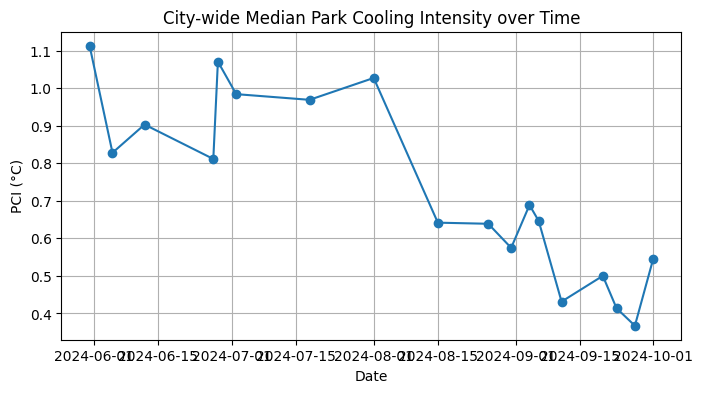

In [ ]:
pci_city = (
    pci_ts
    .groupby("date")["pci_c"]
    .median()
    .reset_index()
)

plt.figure(figsize=(8,4))
plt.plot(pci_city["date"], pci_city["pci_c"], marker="o")
plt.title("City-wide Median Park Cooling Intensity over Time")
plt.ylabel("PCI (°C)")
plt.xlabel("Date")
plt.grid(True)
plt.show()

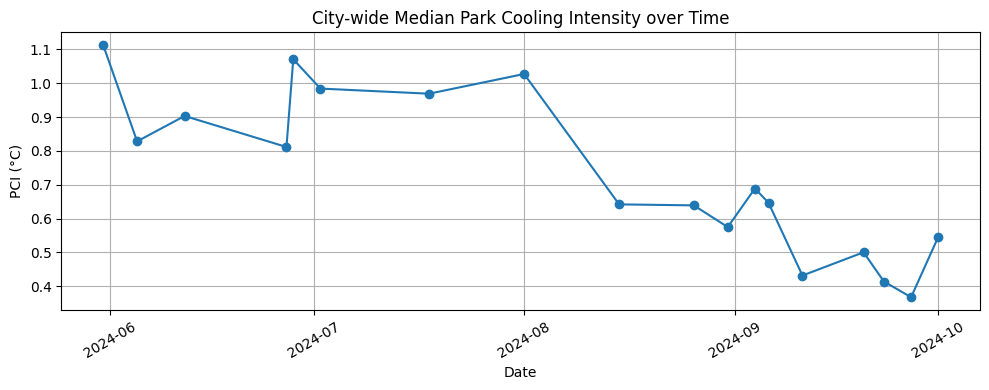

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(pci_city["date"], pci_city["pci_c"], marker="o")

ax.set_title("City-wide Median Park Cooling Intensity over Time")
ax.set_ylabel("PCI (°C)")
ax.set_xlabel("Date")

ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))

plt.xticks(rotation=30)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# City-level PCI time series

pci_city = (
    pci_ts
    .groupby("date")
    .agg(
        median_pci=("pci_c", "median"),
        mean_pci=("pci_c", "mean"),
        q25=("pci_c", lambda x: x.quantile(0.25)),
        q75=("pci_c", lambda x: x.quantile(0.75)),
        n_parks=("pci_c", "count")
    )
    .reset_index()
    .sort_values("date")
)

print(pci_city)

         date  median_pci  mean_pci       q25       q75  n_parks
0  2024-05-31    1.113266  1.202238  0.093140  2.183021      579
1  2024-06-05    0.828079  1.027973 -0.011406  1.916496      579
2  2024-06-12    0.903233  1.058625 -0.006916  2.059298      579
3  2024-06-27    0.811520  1.060336 -0.148838  1.943497      579
4  2024-06-28    1.070942  1.238203  0.115181  2.236290      579
5  2024-07-02    0.984245  1.135629  0.023528  2.141140      579
6  2024-07-18    0.969095  1.100668 -0.031539  2.090352      428
7  2024-08-01    1.027351  1.182009  0.143229  2.059521      579
8  2024-08-15    0.641800  0.759794 -0.115139  1.506421      579
9  2024-08-26    0.638855  0.781864  0.002892  1.507444      579
10 2024-08-31    0.574720  0.558651 -0.455181  1.682270      579
11 2024-09-04    0.688728  0.766826 -0.012508  1.589833      579
12 2024-09-06    0.646564  0.759650 -0.106743  1.577352      579
13 2024-09-11    0.431396  0.432878 -0.204582  1.090645      579
14 2024-09-20    0.500103

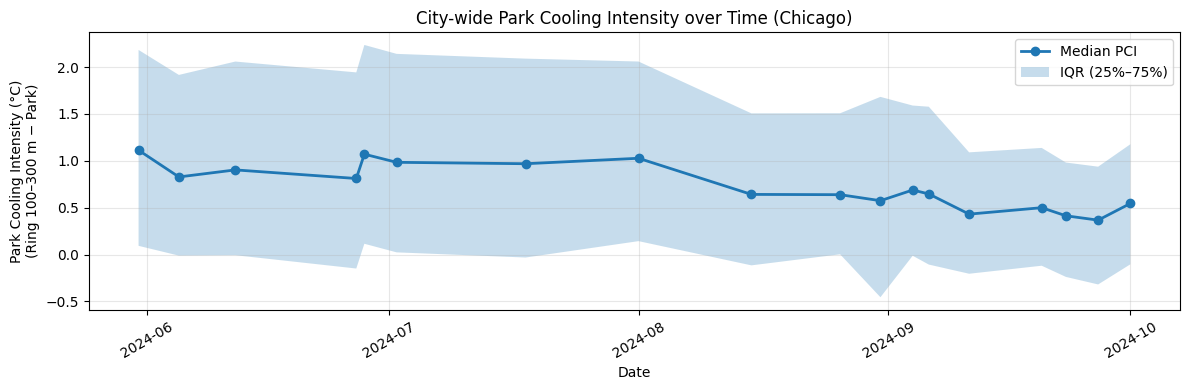

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(12, 4))

# median PCI
ax.plot(
    pci_city["date"],
    pci_city["median_pci"],
    marker="o",
    linewidth=2,
    label="Median PCI"
)

# IQR
ax.fill_between(
    pci_city["date"],
    pci_city["q25"],
    pci_city["q75"],
    alpha=0.25,
    label="IQR (25%–75%)"
)

ax.set_title("City-wide Park Cooling Intensity over Time (Chicago)")
ax.set_ylabel("Park Cooling Intensity (°C)\n(Ring 100–300 m − Park)")
ax.set_xlabel("Date")

ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))

plt.xticks(rotation=30)
plt.grid(True, alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()

# **Is there a seasonal trend**

In [ ]:
from scipy.stats import linregress

x = pci_city["date"].map(pd.Timestamp.toordinal)
y = pci_city["median_pci"]

slope, intercept, r_value, p_value, std_err = linregress(x, y)

print("Linear trend test:")
print(f"  Slope (°C per day): {slope:.6f}")
print(f"  Approx slope (°C per month): {slope * 30:.4f}")
print(f"  R^2: {r_value**2:.3f}")
print(f"  p-value: {p_value:.4f}")

Linear trend test:
  Slope (°C per day): -0.004884
  Approx slope (°C per month): -0.1465
  R^2: 0.743
  p-value: 0.0000


# **Hottest day VS Coldest day**

In [ ]:
# city-wide mean LST per date

city_lst = (
    pci_ts
    .groupby("date")
    .agg(
        mean_city_lst=("ring_mean_c", "mean"),
        median_city_lst=("ring_mean_c", "median")
    )
    .reset_index()
    .sort_values("mean_city_lst")
)

print(city_lst)

         date  mean_city_lst  median_city_lst
17 2024-10-01      29.208765        29.101112
10 2024-08-31      31.228382        34.786755
0  2024-05-31      31.905996        31.967161
12 2024-09-06      32.359970        32.640945
11 2024-09-04      32.650272        32.742165
13 2024-09-11      32.682430        32.679756
16 2024-09-27      33.010765        33.553883
3  2024-06-27      33.765244        34.405338
1  2024-06-05      34.025604        34.094406
8  2024-08-15      34.200100        34.297398
14 2024-09-20      34.424473        34.511028
2  2024-06-12      34.796959        35.187153
5  2024-07-02      35.253605        35.215210
15 2024-09-23      36.505692        36.738556
7  2024-08-01      36.591347        36.555626
4  2024-06-28      38.639214        38.790382
6  2024-07-18      38.787182        39.140152
9  2024-08-26      39.358261        39.349274


In [ ]:
N = 3

hottest_days = city_lst.sort_values("mean_city_lst", ascending=False).head(N)["date"]
coolest_days = city_lst.sort_values("mean_city_lst", ascending=True).head(N)["date"]

print("Hottest days:", list(hottest_days.dt.strftime("%Y-%m-%d")))
print("Coolest days:", list(coolest_days.dt.strftime("%Y-%m-%d")))

Hottest days: ['2024-08-26', '2024-07-18', '2024-06-28']
Coolest days: ['2024-10-01', '2024-08-31', '2024-05-31']


In [ ]:
pci_extreme = pci_ts.copy()
pci_extreme["group"] = pd.Series(pd.NA, index=pci_extreme.index, dtype="string")

pci_extreme.loc[pci_extreme["date"].isin(hottest_days), "group"] = "Hot days"
pci_extreme.loc[pci_extreme["date"].isin(coolest_days), "group"] = "Cool days"

pci_extreme = pci_extreme.dropna(subset=["group"])

print(pci_extreme.groupby("group")["pci_c"].describe())

            count      mean       std       min       25%       50%       75%  \
group                                                                           
Cool days  1737.0  0.763659  1.692771 -9.605288 -0.140167  0.695818  1.610165   
Hot days   1586.0  1.034492  1.581940 -5.985878  0.024528  0.872248  1.891788   

                 max  
group                 
Cool days   7.783813  
Hot days   10.756575  


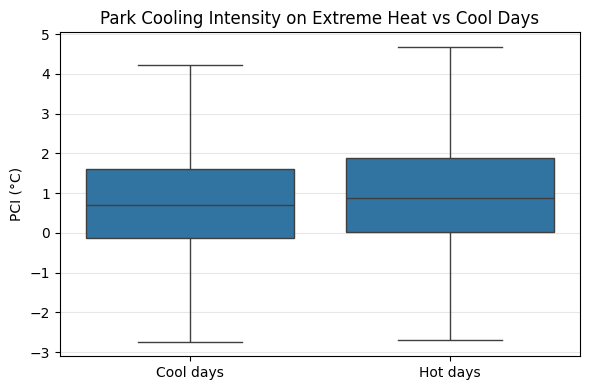

In [ ]:
import seaborn as sns

plt.figure(figsize=(6,4))
sns.boxplot(
    data=pci_extreme,
    x="group",
    y="pci_c",
    showfliers=False
)

plt.title("Park Cooling Intensity on Extreme Heat vs Cool Days")
plt.ylabel("PCI (°C)")
plt.xlabel("")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
from scipy.stats import mannwhitneyu

hot_pci = pci_extreme.loc[pci_extreme["group"]=="Hot days", "pci_c"].dropna()
cool_pci = pci_extreme.loc[pci_extreme["group"]=="Cool days", "pci_c"].dropna()

u_stat, p_val = mannwhitneyu(hot_pci, cool_pci, alternative="greater")

print("Mann–Whitney U test (Hot > Cool):")
print(f"  U statistic: {u_stat:.1f}")
print(f"  p-value: {p_val:.4f}")
print(f"  Hot days median PCI: {hot_pci.median():.3f}")
print(f"  Cool days median PCI: {cool_pci.median():.3f}")

Mann–Whitney U test (Hot > Cool):
  U statistic: 1485113.5
  p-value: 0.0000
  Hot days median PCI: 0.872
  Cool days median PCI: 0.696


# **Park Size VS PCI**

In [ ]:
from scipy.stats import spearmanr

In [ ]:
df = pci_df.copy()

df = df[
    (df["area_acres"] > 0) &
    (df["pci_c"].notna())
].copy()

df["log_area"] = np.log10(df["area_acres"])

In [ ]:
rho, pval = spearmanr(df["log_area"], df["pci_c"])

print("Spearman correlation (log area vs PCI):")
print(f"  rho = {rho:.3f}")
print(f"  p-value = {pval:.4f}")

Spearman correlation (log area vs PCI):
  rho = 0.578
  p-value = 0.0000


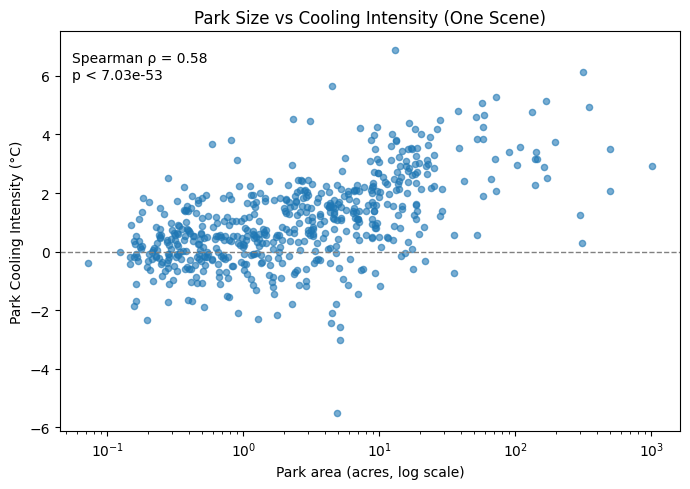

In [ ]:
plt.figure(figsize=(7, 5))
plt.scatter(
    df["area_acres"],
    df["pci_c"],
    alpha=0.6,
    s=20
)

plt.xscale("log")
plt.xlabel("Park area (acres, log scale)")
plt.ylabel("Park Cooling Intensity (°C)")
plt.title("Park Size vs Cooling Intensity (One Scene)")

plt.axhline(0, color="gray", linestyle="--", linewidth=1)

plt.text(
    0.02, 0.95,
    f"Spearman ρ = {rho:.2f}\np < {pval:.3g}",
    transform=plt.gca().transAxes,
    verticalalignment="top"
)

plt.tight_layout()
plt.show()

# **Size VS PCI across time**

In [ ]:
import re
from datetime import datetime

def parse_scene_date(st_b10_name):
    m = re.search(r"_([0-9]{8})_", st_b10_name)
    if m:
        return datetime.strptime(m.group(1), "%Y%m%d")
    return None

In [ ]:
from shapely.geometry import mapping

In [ ]:
neigh_dir = base_path / "neighborhoods"
neigh_shp = next(neigh_dir.glob("*.shp"))

neighborhoods = gpd.read_file(neigh_shp)

print("Neighborhoods loaded:")
print("CRS:", neighborhoods.crs)
print("Rows:", len(neighborhoods))

Neighborhoods loaded:
CRS: EPSG:4326
Rows: 98


In [ ]:
import numpy as np
import pandas as pd
import rasterio
from rasterio.mask import mask
from shapely.geometry import mapping

def compute_scene_pci(st_path,
                      parks_gdf,
                      city_gdf,
                      ring_inner=100,
                      ring_outer=300,
                      min_valid_pixels=30,
                      debug=False,
                      max_debug=10):
    rows = []
    dbg = 0

    with rasterio.open(st_path) as src:
        raster_crs = src.crs
        nodata = src.nodata

        parks_proj = parks_gdf.to_crs(raster_crs)

        for idx, row in parks_proj.iterrows():
            geom = row.geometry
            if geom is None or geom.is_empty:
                continue

            # park
            try:
                park_mask, _ = mask(src, [mapping(geom)], crop=True)
                park_vals = park_mask[0].astype("float32")

                if nodata is not None:
                    park_vals[park_vals == nodata] = np.nan

                park_c = park_vals * 0.00341802 + 149.0 - 273.15

                valid = np.isfinite(park_c)
                if valid.sum() < min_valid_pixels:
                    continue

                park_mean = float(np.nanmean(park_c))
            except Exception as e:
                if debug and dbg < max_debug:
                    print(f"[park fail] idx={idx}: {type(e).__name__}: {e}")
                    dbg += 1
                continue

            # ring
            ring_geom = geom.buffer(ring_outer).difference(geom.buffer(ring_inner))
            if ring_geom.is_empty:
                continue

            try:
                ring_mask, _ = mask(src, [mapping(ring_geom)], crop=True)
                ring_vals = ring_mask[0].astype("float32")
                if nodata is not None:
                    ring_vals[ring_vals == nodata] = np.nan
                ring_c = ring_vals * 0.00341802 + 149.0 - 273.15

                valid = np.isfinite(ring_c)
                if valid.sum() < min_valid_pixels:
                    continue

                ring_mean = float(np.nanmean(ring_c))
            except Exception as e:
                if debug and dbg < max_debug:
                    print(f"[ring fail] idx={idx}: {type(e).__name__}: {e}")
                    dbg += 1
                continue

            acres_val = row.get("acres", np.nan)

            rows.append({
                "park_idx": idx,
                "area_acres": float(acres_val) if pd.notna(acres_val) else np.nan,
                "park_mean_c": park_mean,
                "ring_mean_c": ring_mean,
                "pci_c": ring_mean - park_mean,
            })

    return pd.DataFrame(rows)

In [ ]:
records = []

for st_path in st_files:
    scene_name = st_path.name
    scene_date = parse_scene_date(scene_name)

    df_scene = compute_scene_pci(
        st_path,
        parks_gdf=parks,
        city_gdf=neighborhoods,
        ring_inner=100,
        ring_outer=300,
        min_valid_pixels=30,
        debug=False
    )

    if df_scene is None or len(df_scene) < 30:
        continue

    df_scene = df_scene[
        (df_scene["area_acres"] > 0) &
        (df_scene["pci_c"].notna())
    ].copy()

    if len(df_scene) < 30:
        continue

    rho, pval = spearmanr(np.log10(df_scene["area_acres"]), df_scene["pci_c"])

    records.append({
        "date": scene_date,
        "scene": scene_name,
        "spearman_rho": float(rho),
        "p_value": float(pval),
        "median_pci": float(df_scene["pci_c"].median()),
        "mean_pci": float(df_scene["pci_c"].mean()),
        "n_parks": int(len(df_scene))
    })

pci_time_corr = pd.DataFrame(records).sort_values("date").reset_index(drop=True)

print("Scenes processed:", len(pci_time_corr))
pci_time_corr

Scenes processed: 18


,date,scene,spearman_rho,p_value,median_pci,mean_pci,n_parks
0,2024-05-22,LC08_L2SP_022031_20240522_20240605_02_T1_ST_B1...,0.227472,0.003113,2.082851,1.849273,167
1,2024-05-30,LC09_L2SP_022031_20240530_20240531_02_T1_ST_B1...,0.197514,0.010512,2.346954,2.197992,167
2,2024-06-06,LC09_L2SP_023031_20240606_20240612_02_T1_ST_B1...,0.207416,0.007154,2.241333,2.057408,167
3,2024-06-07,LC08_L2SP_022031_20240607_20240627_02_T1_ST_B1...,0.243714,0.001504,2.020447,1.820920,167
4,2024-06-14,LC08_L2SP_023031_20240614_20240628_02_T1_ST_B1...,0.202475,0.008687,2.338028,2.185009,167
5,2024-07-01,LC09_L2SP_022031_20240701_20240702_02_T1_ST_B1...,0.215300,0.005202,2.138210,2.012992,167
6,2024-07-17,LC09_L2SP_022031_20240717_20240718_02_T1_ST_B1...,0.158255,0.101876,2.176809,1.946160,108
7,2024-07-25,LC08_L2SP_022031_20240725_20240801_02_T1_ST_B1...,0.190418,0.013707,2.266487,2.121687,167
8,2024-08-10,LC08_L2SP_022031_20240810_20240815_02_T1_ST_B1...,0.195572,0.011313,1.352785,1.439228,167
9,2024-08-25,LC09_L2SP_023031_20240825_20240826_02_T1_ST_B1...,0.181088,0.019181,1.330021,1.222118,167


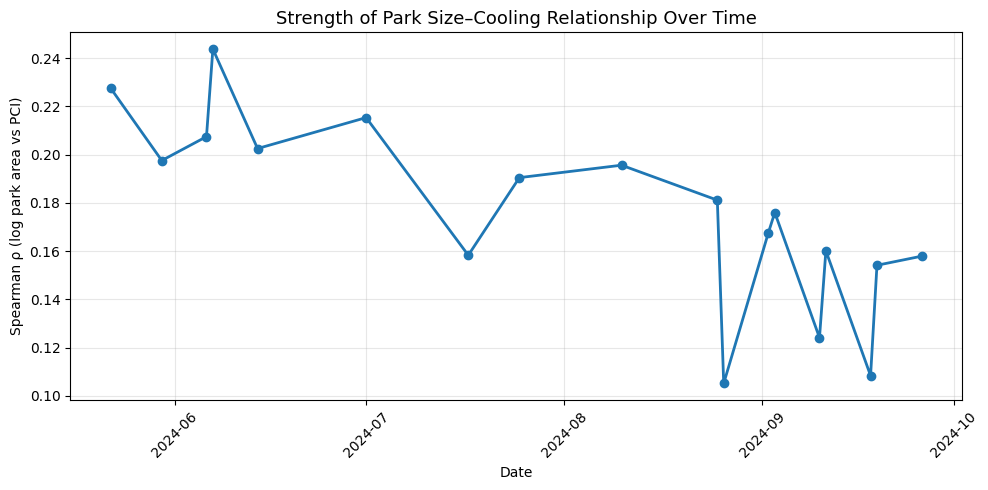

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(
    pci_time_corr["date"],
    pci_time_corr["spearman_rho"],
    marker="o",
    linewidth=2
)

ax.set_title("Strength of Park Size–Cooling Relationship Over Time", fontsize=13)
ax.set_ylabel("Spearman ρ (log park area vs PCI)")
ax.set_xlabel("Date")

ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.xticks(rotation=45)

ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

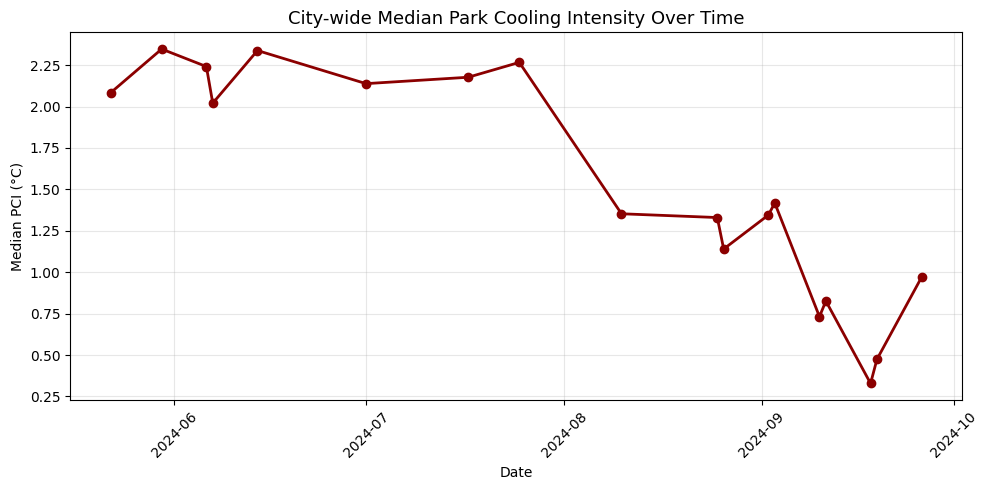

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(
    pci_time_corr["date"],
    pci_time_corr["median_pci"],
    marker="o",
    linewidth=2,
    color="darkred"
)

ax.set_title("City-wide Median Park Cooling Intensity Over Time", fontsize=13)
ax.set_ylabel("Median PCI (°C)")
ax.set_xlabel("Date")

ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.xticks(rotation=45)

ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()